# Amazon Fine Food Reviews Analysis - Clustering

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from scipy.stats import uniform
from scipy.sparse import csr_matrix
from collections import Counter

from prettytable import PrettyTable

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

('Number of data points in our data', (525814, 10))


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [10]:
#Deduplication of entries
#final=sorted_data.drop_duplicates(subset={"Score"}, keep='first', inplace=False)
#final.shape

final_pos_reviews=final.loc[final['Score'] == 1]
final_neg_reviews=final.loc[final['Score']== 0]

In [11]:
final=final.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=final.sort_values('Time')
final_new=final[:80000]
labels = final_new['Score']

In [12]:

final=final_new
new_labels=final['Score']

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [13]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

8
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ksumanth01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

set([u'all', u'just', u"don't", u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'o', u'don', u'hadn', u'herself', u'll', u'had', u'should', u'to', u'only', u'won', u'under', u'ours', u'has', u"should've", u"haven't", u'do', u'them', u'his', u'very', u"you've", u'they', u'not', u'during', u'now', u'him', u'nor', u"wasn't", u'd', u'did', u'didn', u'this', u'she', u'each', u'further', u"won't", u'where', u"mustn't", u"isn't", u'few', u'because', u"you'd", u'doing', u'some', u'hasn', u"hasn't", u'are', u'our', u'ourselves', u'out', u'what', u'for', u"needn't", u'below', u're', u'does', u"shouldn't", u'above', u'between', u'mustn', u't', u'be', u'we', u'who', u"mightn't", u"doesn't", u'were', u'here', u'shouldn', u'hers', u"aren't", u'by', u'on', u'about', u'couldn', u'of', u"wouldn't", u'against', u's', u'isn', u'or', u'own', u'into', u'yourself', u'down', u"hadn't", u'mightn', u"couldn't", u'wasn', u'your', u"you're", u'from', u'her', u'their', u'aren', u"it's",

In [16]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

100%|██████████| 80000/80000 [01:40<00:00, 794.63it/s] 


In [17]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

# Bag of Words - Unigrams

In [41]:
# Dividing raw train and test data
X = final['CleanedText']

In [42]:
# Applying bow on train data
count_vect = CountVectorizer()
X_final = count_vect.fit_transform(X)
print(X_final.shape)

(80000, 33425)


In [43]:
# Standardizing X
scaler = preprocessing.StandardScaler(with_mean=False)
# Fit your data on the scaler object
standardized_X = scaler.fit_transform(X_final)

## Applying K-Means

In [21]:
%%time
from sklearn.cluster import KMeans
param=[2,3,5,10,13,18]
scores=[]
def func(param):
    for i in range(len(param)):
        kmeans=KMeans(random_state=2,n_jobs=-1,n_clusters=param[i]).fit(standardized_X)
        scores.append(kmeans.inertia_)
        
func(param)

CPU times: user 11min 24s, sys: 2min 33s, total: 13min 58s
Wall time: 10min 14s


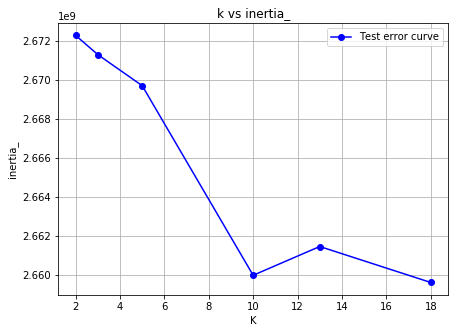

In [22]:
plt.figure(figsize=(7,5))
plt.plot( param, scores, linestyle='-', marker='o',color="blue")
plt.title('k vs inertia_')
plt.legend(['Test error curve'])
plt.xlabel('K')
plt.ylabel('inertia_')
plt.grid(True)

Proper elbow was not seen as there were fluctuations even after elbow. So n_clusters=3 is choosen.

In [23]:
kmeans = KMeans(random_state=2,n_clusters=3,n_jobs=-1).fit(standardized_X)

In [24]:
# Getting review indexes according to the clusters
cluster_labels=kmeans.labels_
n=3
indexes=[]
for j in range(n):
    index=[i for i,x in enumerate(cluster_labels) if x == j]
    indexes.append(index)

In [25]:
# Getting review words according to the clusters
cluster_words=[]
for j in range(n):
    index_list=indexes[j]
    words=' '
    for i in index_list:
        stmt=X[i]
        words=words+stmt+' '
    cluster_words.append(words)

In [26]:
# Plotting word cloud for each clusters
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)
wordcloud=[]
for i in range(n):
    wc=WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster_words[i])
    wordcloud.append(wc)

In [27]:
# Printing word clouds
fig = plt.figure(figsize=(15,15),facecolor=None)
for i in range(n):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(wordcloud[i])
    tit='Cluster '+str(i)
    ax.set_title(tit)
    ax.axis('off')

Popular words of cluster 0: one, use, love, good.
Popular words of cluster 1: gusto, crema, non, froci.
Popular words of cluster 2: good, dead, hell, dark.

## Agglomerative Clustering

In [23]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_samples, silhouette_score

# svd on X
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
svd_X=svd.fit_transform(standardized_X[:5000])

In [24]:
%%time
clusters=[2,3,5,10,13,18]
scores=[]
for i in clusters:
    clf = AgglomerativeClustering(n_clusters=i).fit(svd_X)
    sil_avg = silhouette_score(svd_X, clf.labels_)
    scores.append(sil_avg)

CPU times: user 30.8 s, sys: 5.19 s, total: 35.9 s
Wall time: 28.1 s


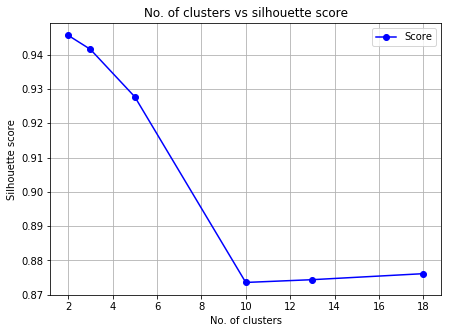

In [25]:
plt.figure(figsize=(7,5))
plt.plot( clusters, scores, linestyle='-', marker='o',color="blue")
plt.title('No. of clusters vs silhouette score')
plt.legend(['Score'])
plt.xlabel('No. of clusters')
plt.ylabel('Silhouette score')
plt.grid(True)

Highest silhouette score is observed at cluster=2 which is 0.94 and cluster number is choosen as 2.

In [26]:
# Getting best no. of cluster

best_n=n=clusters[scores.index(max(scores))]
print "Optimal number of clusters ",best_n
clf = AgglomerativeClustering(n_clusters=best_n).fit(svd_X)

Optimal number of clusters  2


In [27]:
# Getting review indexes according to the clusters
cluster_labels=clf.labels_
indexes=[]
for j in range(n):
    index=[i for i,x in enumerate(cluster_labels) if x == j]
    indexes.append(index)

In [28]:
# Getting review words according to the clusters
cluster_words=[]
for j in range(n):
    index_list=indexes[j]
    words=' '
    for i in index_list:
        stmt=X[i]
        words=words+stmt+' '
    cluster_words.append(words)

In [29]:
# Plotting word cloud for each clusters
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)
wordcloud=[]
for i in range(n):
    wc=WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster_words[i])
    wordcloud.append(wc)

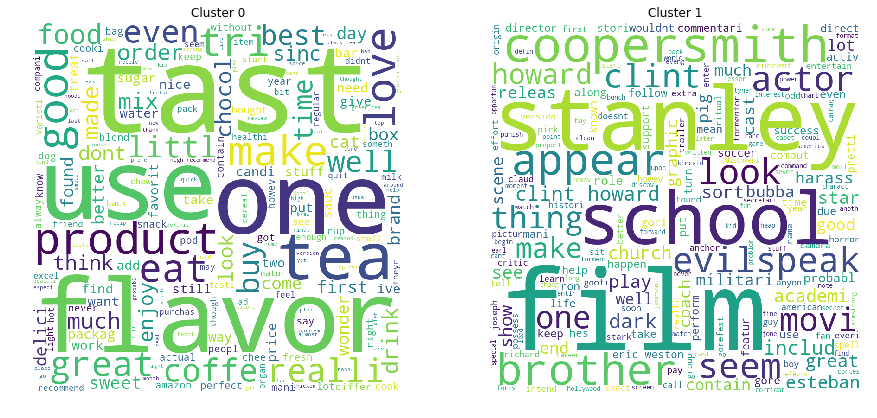

In [30]:
# Printing word clouds
fig = plt.figure(figsize=(15,15),facecolor=None)
for i in range(n):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(wordcloud[i])
    tit='Cluster '+str(i)
    ax.set_title(tit)
    ax.axis('off')

Popular words of cluster 0: flavor, tast, use, one.  Popular words of cluster 1: film, stanley, school, brother.

## DBSCAN Clustering

In [18]:
X = final['CleanedText']
# Applying bow on train data
count_vect = CountVectorizer()
X_final = count_vect.fit_transform(X[:10000])
print(X_final.shape)
# Standardizing X
scaler = preprocessing.StandardScaler(with_mean=False)
# Fit your data on the scaler object
standardized_X = scaler.fit_transform(X_final)

(10000, 14146)


Best eps is around 40 from above plot.

In [49]:
%%time
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=80,min_samples=10).fit(standardized_X)
cluster_labels=clustering.labels_ 
outlier_length=len([i for i,x in enumerate(cluster_labels) if x == -1])
print "No. of points classified as outliers: ",outlier_length

No. of points classified as outliers:  4684
CPU times: user 3.35 s, sys: 901 ms, total: 4.25 s
Wall time: 4.25 s


In [50]:
w=list(set(cluster_labels))
dicti={}
for j in range(len(w)):
    # Getting review indexes according to the clusters
    if w[j]!=-1:
        index=[i for i,x in enumerate(cluster_labels) if x == j]
        dicti[w[j]]=index

In [51]:
print "No of clusters: ",len(dicti)

No of clusters:  1


In [52]:
# Getting review words according to the clusters
cluster_words=[]
for j in range(len(dicti.keys())):
    index_list=dicti[j]
    words=' '
    for i in index_list:
        stmt=X[i]
        words=words+stmt+' '
    cluster_words.append(words)

In [53]:
# Plotting word cloud for each clusters
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)
wordcloud=[]
for i in range(len(dicti.keys())):
    wc=WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster_words[i])
    wordcloud.append(wc)

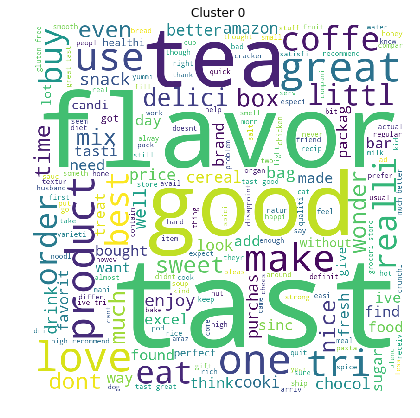

In [54]:
# Printing word clouds
fig = plt.figure(figsize=(15,15),facecolor=None)
for i in range(len(dicti.keys())):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(wordcloud[i])
    tit='Cluster '+str(i)
    ax.set_title(tit)
    ax.axis('off')

Popular words of cluster 0: flavor, tast, good, tea.

# TF-IDF Featurization

In [18]:
# Dividing raw train and test data
X = final['CleanedText']

# TF-IDF Vectorizing
# vectorizing X
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tfidf = tf_idf_vect.fit_transform(X)
print("Data shape: ",final_tfidf.get_shape())

('Data shape: ', (80000, 1014048))


In [19]:
# Standardizing X
scaler = preprocessing.StandardScaler(with_mean=False)
# Fit your data on the scaler object
standardized_X = scaler.fit_transform(final_tfidf)

## Applying K-Means

In [35]:
%%time
from sklearn.cluster import KMeans
param=[2,3,5,10,13,18]
scores=[]
def func(param):
    for i in range(len(param)):
        kmeans=KMeans(random_state=2,n_jobs=-1,n_clusters=param[i]).fit(standardized_X)
        scores.append(kmeans.inertia_)
        
func(param)

CPU times: user 18min 3s, sys: 2min 2s, total: 20min 5s
Wall time: 18min 4s


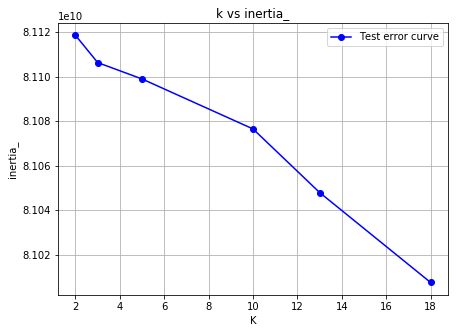

In [36]:
plt.figure(figsize=(7,5))
plt.plot( clusters, scores, linestyle='-', marker='o',color="blue")
plt.title('k vs inertia_')
plt.legend(['Test error curve'])
plt.xlabel('K')
plt.ylabel('inertia_')
plt.grid(True)

No proper elbow is seen in the above plot. So n_clusters is choosen as 3.

In [37]:
kmeans = KMeans(random_state=2,n_clusters=3,n_jobs=-1).fit(standardized_X)

In [38]:
# Getting review indexes according to the clusters
cluster_labels=kmeans.labels_
n=3
indexes=[]
for j in range(n):
    index=[i for i,x in enumerate(cluster_labels) if x == j]
    indexes.append(index)

In [39]:
# Getting review words according to the clusters
cluster_words=[]
for j in range(n):
    index_list=indexes[j]
    words=' '
    for i in index_list:
        stmt=X[i]
        words=words+stmt+' '
    cluster_words.append(words)

In [40]:
# Plotting word cloud for each clusters
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)
wordcloud=[]
for i in range(n):
    wc=WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster_words[i])
    wordcloud.append(wc)

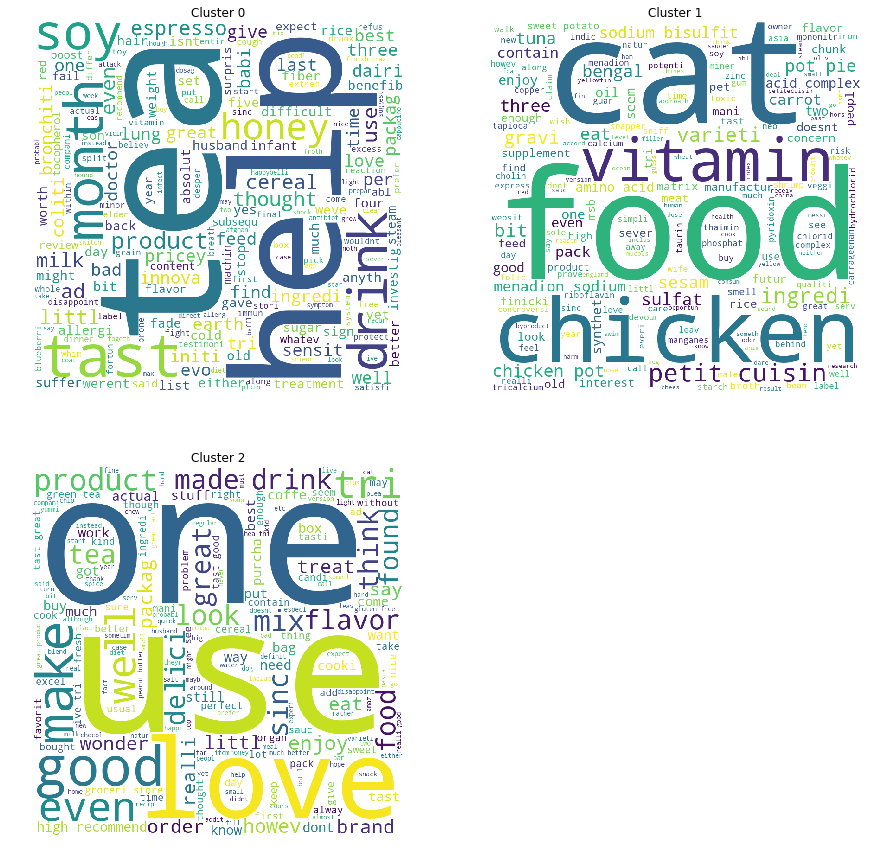

In [41]:
# Printing word clouds
fig = plt.figure(figsize=(15,15),facecolor=None)
for i in range(n):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(wordcloud[i])
    tit='Cluster '+str(i)
    ax.set_title(tit)
    ax.axis('off')

Popular words found in cluster 0: tea, help, soy, drink. Popular words found in cluster 1:food,cat,vitamin,chicken.    Popular words found in cluster 2: use,love,one,good.

## Agglomerative Clustering

In [42]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_samples, silhouette_score

# svd on X
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
svd_X=svd.fit_transform(standardized_X[:5000])

In [43]:
%%time
clusters=[2,3,5,10,13,18]
scores=[]
for i in clusters:
    clf = AgglomerativeClustering(n_clusters=i).fit(svd_X)
    sil_avg = silhouette_score(svd_X, clf.labels_)
    scores.append(sil_avg)

CPU times: user 32.9 s, sys: 5.15 s, total: 38.1 s
Wall time: 30.6 s


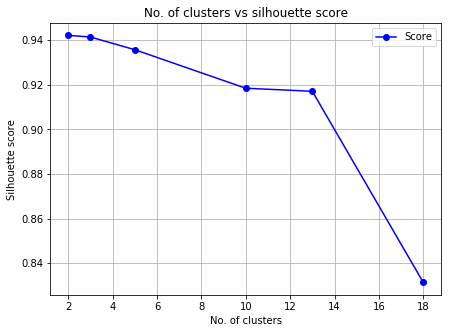

In [44]:
plt.figure(figsize=(7,5))
plt.plot( clusters, scores, linestyle='-', marker='o',color="blue")
plt.title('No. of clusters vs silhouette score')
plt.legend(['Score'])
plt.xlabel('No. of clusters')
plt.ylabel('Silhouette score')
plt.grid(True)

Highest value of silhouette score is obtained for no. of clusters 2 which is 0.94.

In [45]:
# Getting best no. of cluster

best_n=n=clusters[scores.index(max(scores))]
print "Optimal number of clusters ",best_n
clf = AgglomerativeClustering(n_clusters=best_n).fit(svd_X)

Optimal number of clusters  2


In [46]:
# Getting review indexes according to the clusters
cluster_labels=clf.labels_
indexes=[]
for j in range(n):
    index=[i for i,x in enumerate(cluster_labels) if x == j]
    indexes.append(index)

In [47]:
# Getting review words according to the clusters
cluster_words=[]
for j in range(n):
    index_list=indexes[j]
    words=' '
    for i in index_list:
        stmt=X[i]
        words=words+stmt+' '
    cluster_words.append(words)

In [48]:
# Plotting word cloud for each clusters
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)
wordcloud=[]
for i in range(n):
    wc=WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster_words[i])
    wordcloud.append(wc)

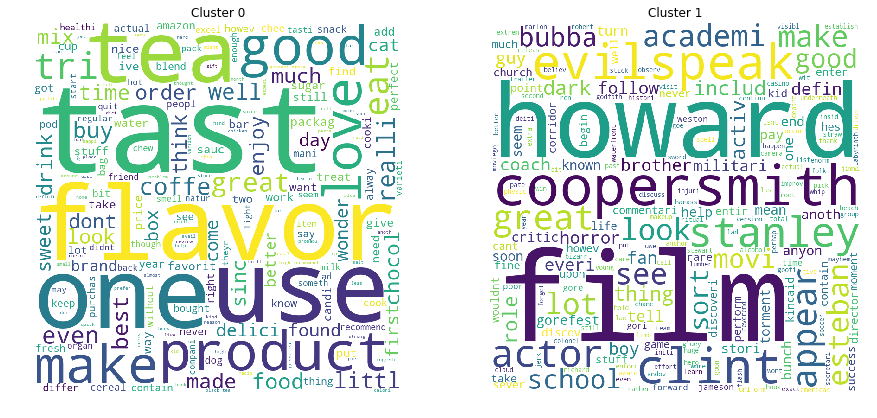

In [49]:
# Printing word clouds
fig = plt.figure(figsize=(15,15),facecolor=None)
for i in range(n):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(wordcloud[i])
    tit='Cluster '+str(i)
    ax.set_title(tit)
    ax.axis('off')

Popular words of cluster 0: tast,flavor,one,use and popular words of cluster 1: film,howard,evilspeak,clint.

## DBSCAN Clustering

In [55]:
# Dividing raw train and test data
X = final['CleanedText']

# TF-IDF Vectorizing
# vectorizing X
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tfidf = tf_idf_vect.fit_transform(X[:10000])
print("Data shape: ",final_tfidf.get_shape())

('Data shape: ', (10000, 229732))


In [56]:
# Standardizing X
scaler = preprocessing.StandardScaler(with_mean=False)
# Fit your data on the scaler object
standardized_X = scaler.fit_transform(final_tfidf)

In [64]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=450,min_samples=12).fit(standardized_X)
cluster_labels=clustering.labels_ 
outlier_length=len([i for i,x in enumerate(cluster_labels) if x == -1])
print "No. of points classified as outliers: ",outlier_length

No. of points classified as outliers:  3931


In [65]:
dicti={}
for j in range(len(w)):
    # Getting review indexes according to the clusters
    if w[j]!=-1:
        index=[i for i,x in enumerate(cluster_labels) if x == j]
        dicti[w[j]]=index

In [66]:
print "No of clusters: ",len(dicti)

No of clusters:  1


In [67]:
# Getting review words according to the clusters
cluster_words=[]
for j in range(len(dicti.keys())):
    index_list=dicti[j]
    words=' '
    for i in index_list:
        stmt=X[i]
        words=words+stmt+' '
    cluster_words.append(words)

In [68]:
# Plotting word cloud for each clusters
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)
wordcloud=[]
for i in range(len(dicti.keys())):
    wc=WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster_words[i])
    wordcloud.append(wc)

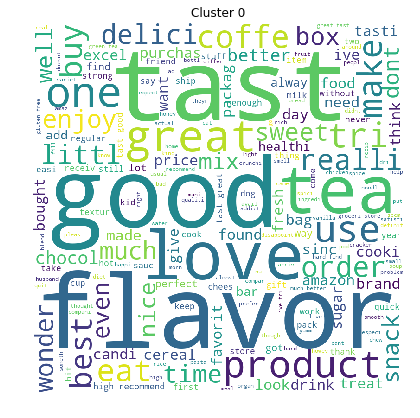

In [69]:
# Printing word clouds
fig = plt.figure(figsize=(15,15),facecolor=None)
for i in range(len(dicti.keys())):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(wordcloud[i])
    tit='Cluster '+str(i)
    ax.set_title(tit)
    ax.axis('off')

Popular words of cluster 0 are flavor,tast,good,love,etc.

#  Word2Vec Featurization

In [70]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need
is_your_ram_gt_16g=False
want_to_read_sub_set_of_google_w2v = True
want_to_read_whole_google_w2v = True
if not is_your_ram_gt_16g:
    if want_to_read_sub_set_of_google_w2v and  os.path.isfile('google_w2v_for_amazon.pkl'):
        with open('google_w2v_for_amazon.pkl', 'rb') as f:
            # model is dict object, you can directly access any word vector using model[word]
            model = pickle.load(f)
else:
    if want_to_read_whole_google_w2v and os.path.isfile('GoogleNews-vectors-negative300.bin'):
        model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# print("the vector representation of word 'computer'",model.wv['computer'])
# print("the similarity between the words 'woman' and 'man'",model.wv.similarity('woman', 'man'))
# print("the most similar words to the word 'woman'",model.wv.most_similar('woman'))
# this will raise an error
# model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

## Average W2V

In [117]:
# Dividing raw train and test data
X = final['CleanedText']

In [118]:
# Training Word2Vec model using own text corpus
list_of_sent=[]
for sent in X:
    list_of_sent.append(sent.split())

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

('number of words that occured minimum 5 times ', 11363)
('sample words ', [u'woodi', u'yellow', u'interchang', u'four', u'cherrio', u'overprocess', u'decaffin', u'mcdougal', u'lord', u'digit', u'chlorophyl', u'bruschetta', u'deli', u'mcilhenni', u'figi', u'furikak', u'foul', u'taj', u'whoopi', u'disturb', u'prize', u'broiler', u'wooden', u'showcas', u'pingshui', u'wednesday', u'ooop', u'superfood', u'nissin', u'oooh', u'cheeto', u'tumer', u'rustl', u'miller', u'seper', u'millet', u'second', u'fece', u'sooth', u'bbqd', u'lucious', u'captain', u'quercetin', u'thunder', u'succumb', u'ongo', u'avers', u'intellectu', u'hero', u'avert'])


In [119]:
# Vectorizing  X
# compute average word2vec for each review.
X_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_sent_vectors.append(sent_vec)
X_sent_vectors=csr_matrix(X_sent_vectors)

100%|██████████| 80000/80000 [16:45<00:00, 79.57it/s] 


In [120]:
# Standardizing X
scaler = preprocessing.StandardScaler(with_mean=False)
# Fit your data on the scaler object
standardized_X = scaler.fit_transform(X_sent_vectors)

## Applying K-Means

In [23]:
%%time
from sklearn.cluster import KMeans
param=[2,3,5,10,13,18]
scores=[]
def func(param):
    for i in tqdm(range(len(param))):
        kmeans=KMeans(random_state=2,n_jobs=-1,n_clusters=param[i]).fit(standardized_X)
        scores.append(kmeans.inertia_)
        
func(param)

100%|██████████| 6/6 [3:18:23<00:00, 2528.49s/it]

CPU times: user 3h 18min 7s, sys: 16.3 s, total: 3h 18min 24s
Wall time: 3h 18min 24s


In [24]:
print scores

[3649116.8325949125, 3360797.1385526056, 3055240.092373031, 2715749.029107858, 2608815.9409805625, 2492495.1762759676]


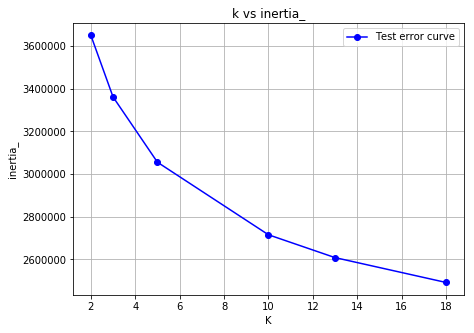

In [26]:
plt.figure(figsize=(7,5))
plt.plot( param, scores, linestyle='-', marker='o',color="blue")
plt.title('k vs inertia_')
plt.legend(['Test error curve'])
plt.xlabel('K')
plt.ylabel('inertia_')
plt.grid(True)

No proper elbow is seen in the above plot. So n_cluster is choosen as 2.

In [27]:
kmeans = KMeans(random_state=2,n_clusters=2,n_jobs=-1).fit(standardized_X)

In [30]:
# Getting review indexes according to the clusters
cluster_labels=kmeans.labels_
n=2
indexes=[]
for j in range(n):
    index=[i for i,x in enumerate(cluster_labels) if x == j]
    indexes.append(index)

In [31]:
# Getting review words according to the clusters
cluster_words=[]
for j in range(n):
    index_list=indexes[j]
    words=' '
    for i in tqdm(index_list):
        stmt=X[i]
        words=words+stmt+' '
    cluster_words.append(words)

100%|██████████| 33827/33827 [04:45<00:00, 118.68it/s]


In [32]:
# Plotting word cloud for each clusters
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)
wordcloud=[]
for i in tqdm(range(n)):
    wc=WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster_words[i])
    wordcloud.append(wc)

100%|██████████| 2/2 [00:32<00:00, 17.27s/it]


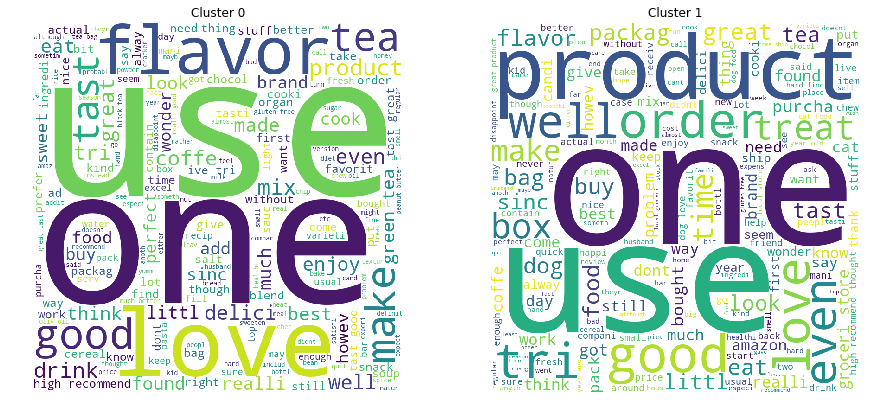

In [33]:
# Printing word clouds
fig = plt.figure(figsize=(15,15),facecolor=None)
for i in range(n):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(wordcloud[i])
    tit='Cluster '+str(i)
    ax.set_title(tit)
    ax.axis('off')

Popular words of cluster 0: use,one,love,flavor,etc.   popular words of cluster 1:  one,use,product,good.

## Agglomerative Clustering

In [121]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_samples, silhouette_score

In [122]:
%%time
standardized_X=standardized_X[:5000].todense()
clusters=[2,3,5,10,13,18]
scores=[]
for i in clusters:
    clf = AgglomerativeClustering(n_clusters=i).fit(standardized_X)
    sil_avg = silhouette_score(standardized_X, clf.labels_)
    scores.append(sil_avg)

CPU times: user 13.9 s, sys: 3.52 s, total: 17.4 s
Wall time: 11.9 s


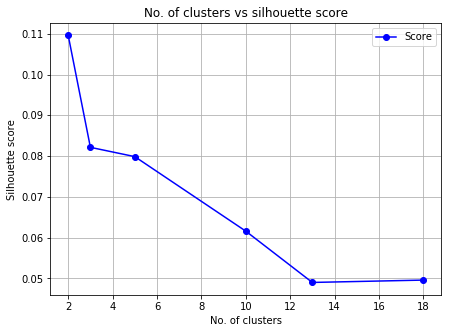

In [123]:
plt.figure(figsize=(7,5))
plt.plot( clusters, scores, linestyle='-', marker='o',color="blue")
plt.title('No. of clusters vs silhouette score')
plt.legend(['Score'])
plt.xlabel('No. of clusters')
plt.ylabel('Silhouette score')
plt.grid(True)

Highest silhouette score is observed for n_clusters = 2 which is 0.11.

In [124]:
# Getting best no. of cluster

best_n=n=clusters[scores.index(max(scores))]
print "Optimal number of clusters ",best_n
clf = AgglomerativeClustering(n_clusters=best_n).fit(standardized_X)

Optimal number of clusters  2


In [125]:
# Getting review indexes according to the clusters
cluster_labels=clf.labels_
indexes=[]
for j in range(n):
    index=[i for i,x in enumerate(cluster_labels) if x == j]
    indexes.append(index)

In [126]:
# Getting review words according to the clusters
cluster_words=[]
for j in range(n):
    index_list=indexes[j]
    words=' '
    for i in index_list:
        stmt=X[i]
        words=words+stmt+' '
    cluster_words.append(words)

In [127]:
# Plotting word cloud for each clusters
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)
wordcloud=[]
for i in range(n):
    wc=WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster_words[i])
    wordcloud.append(wc)

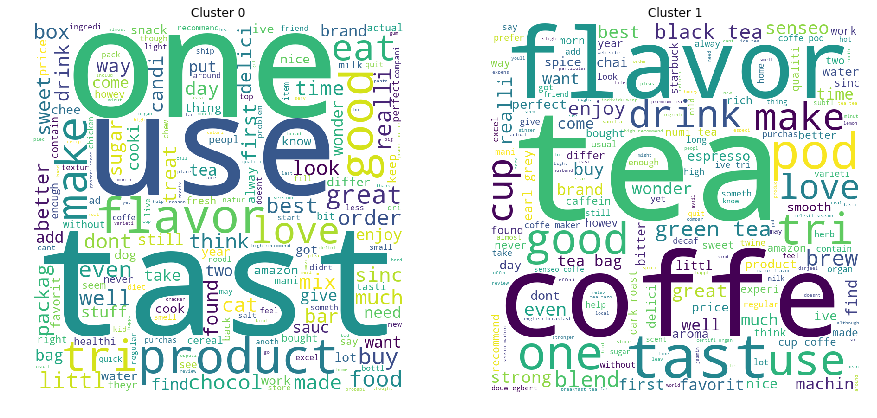

In [128]:
# Printing word clouds
fig = plt.figure(figsize=(15,15),facecolor=None)
for i in range(n):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(wordcloud[i])
    tit='Cluster '+str(i)
    ax.set_title(tit)
    ax.axis('off')

Popular words of cluster 0: one,use,tast,product and popular words of cluster 1:tea,coffe,flavor,tast,etc.

## DBSCAN Clustering

In [79]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=5,min_samples=10).fit(standardized_X[:10000])
cluster_labels=clustering.labels_ 
outlier_length=len([i for i,x in enumerate(cluster_labels) if x == -1])
print "No. of points classified as outliers: ",outlier_length

No. of points classified as outliers:  2772


In [80]:
w=list(set(cluster_labels))
dicti={}
for j in tqdm(range(len(w))):
    # Getting review indexes according to the clusters
    if w[j]!=-1:
        index=[i for i,x in enumerate(cluster_labels) if x == j]
        dicti[w[j]]=index

100%|██████████| 2/2 [00:00<00:00, 288.97it/s]


In [81]:
print "No of clusters: ",len(dicti)

No of clusters:  1


In [82]:
# Getting review words according to the clusters
cluster_words=[]
for j in range(len(dicti.keys())):
    index_list=dicti[j]
    words=' '
    for i in index_list:
        stmt=X[i]
        words=words+stmt+' '
    cluster_words.append(words)

In [83]:
# Plotting word cloud for each clusters
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)
wordcloud=[]
for i in range(len(dicti.keys())):
    wc=WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster_words[i])
    wordcloud.append(wc)

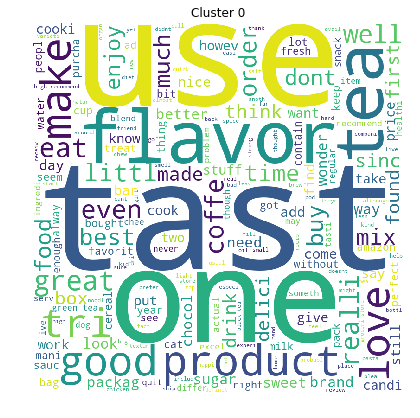

In [84]:
# Printing word clouds
fig = plt.figure(figsize=(15,15),facecolor=None)
for i in range(len(dicti.keys())):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(wordcloud[i])
    tit='Cluster '+str(i)
    ax.set_title(tit)
    ax.axis('off')

Popular words of cluster 0: use,tast,one,flavor,tea,etc.

# TF-IDF weighted W2V

In [85]:
X = final['CleanedText']

In [86]:
# Vectorizing X
i=0
list_of_sent1=[]
for sent in X:
    list_of_sent1.append(sent.split())

w2v_model=Word2Vec(list_of_sent1,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
sent_vectors=csr_matrix(tfidf_sent_vectors)

100%|██████████| 80000/80000 [16:42<00:00, 79.81it/s] 


In [87]:
# Standardizing X
scaler = preprocessing.StandardScaler(with_mean=False)
# Fit your data on the scaler object
standardized_X = scaler.fit_transform(sent_vectors)

## Applying K-Means

In [89]:
%%time
from sklearn.cluster import KMeans
param=[2,3,5,10,13,18]
scores=[]
def func(param):
    for i in tqdm(range(len(param))):
        kmeans=KMeans(random_state=2,n_jobs=-1,n_clusters=param[i]).fit(standardized_X)
        scores.append(kmeans.inertia_)
        
func(param)
print scores

100%|██████████| 6/6 [3:07:49<00:00, 2351.06s/it]

[3603043.326471031, 3342339.5159027753, 3002481.723679427, 2596773.1205097195, 2480212.492318725, 2343565.2928317646]
CPU times: user 3h 7min 50s, sys: 0 ns, total: 3h 7min 50s
Wall time: 3h 7min 49s


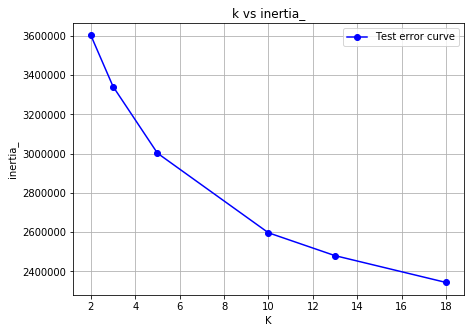

In [90]:
plt.figure(figsize=(7,5))
plt.plot( param, scores, linestyle='-', marker='o',color="blue")
plt.title('k vs inertia_')
plt.legend(['Test error curve'])
plt.xlabel('K')
plt.ylabel('inertia_')
plt.grid(True)

No elbow is observed in the above plot so n_clusters is choosen as 3.

In [91]:
kmeans = KMeans(random_state=2,n_clusters=3,n_jobs=-1).fit(standardized_X)

In [92]:
# Getting review indexes according to the clusters
cluster_labels=kmeans.labels_
n=3
indexes=[]
for j in tqdm(range(n)):
    index=[i for i,x in enumerate(cluster_labels) if x == j]
    indexes.append(index)

In [93]:
# Getting review words according to the clusters
cluster_words=[]
for j in range(n):
    index_list=indexes[j]
    words=' '
    for i in tqdm(index_list):
        stmt=X[i]
        words=words+stmt+' '
    cluster_words.append(words)

In [94]:
# Plotting word cloud for each clusters
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)
wordcloud=[]
for i in tqdm(range(n)):
    wc=WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster_words[i])
    wordcloud.append(wc)

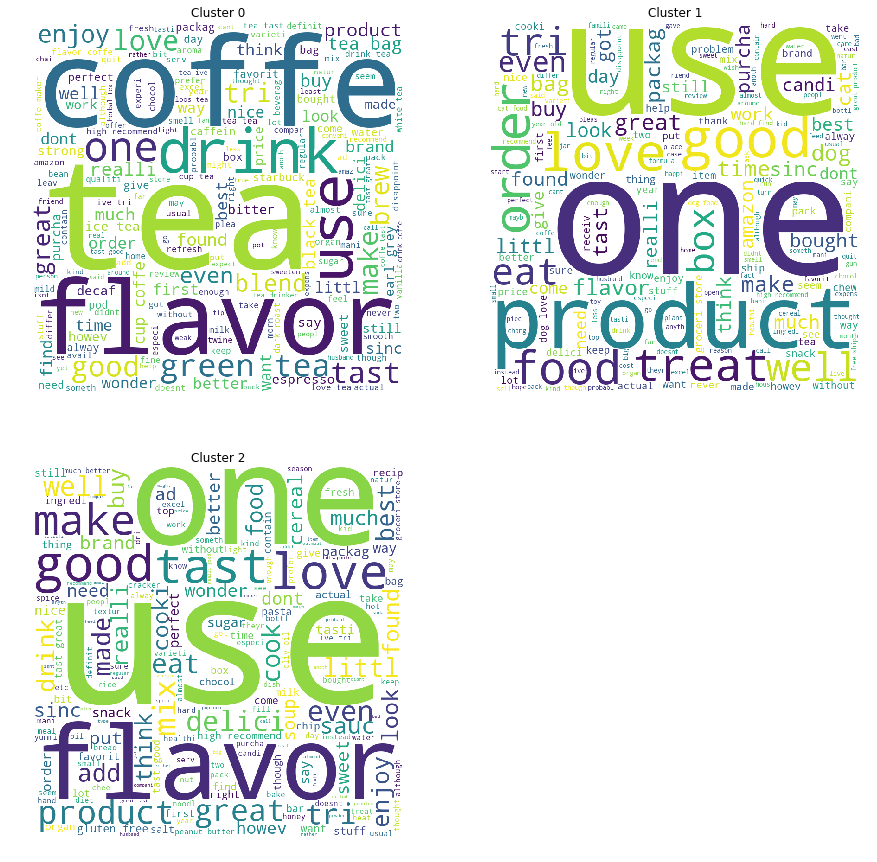

In [95]:
# Printing word clouds
fig = plt.figure(figsize=(15,15),facecolor=None)
for i in range(n):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(wordcloud[i])
    tit='Cluster '+str(i)
    ax.set_title(tit)
    ax.axis('off')

Popular words found in cluster 0:tea,coffe,flavor,drink. popular words found in cluster  1:one,use,product,good,etc. popular words found in cluster 2: use,one,flavor,love,good.

## Agglomerative Clustering

In [96]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_samples, silhouette_score

In [97]:
%%time
standardized_X=standardized_X[:5000].toarray()
clusters=[2,3,5,10,13,18]
scores=[]
for i in clusters:
    clf = AgglomerativeClustering(n_clusters=i).fit(standardized_X)
    sil_avg = silhouette_score(standardized_X, clf.labels_)
    scores.append(sil_avg)

CPU times: user 16.1 s, sys: 1.15 s, total: 17.3 s
Wall time: 11.9 s


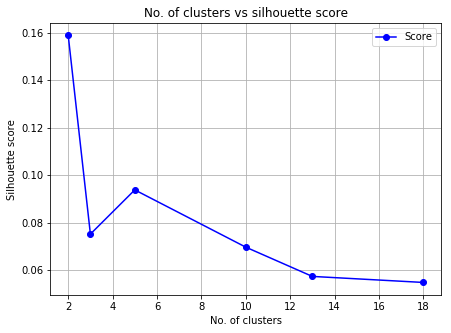

In [98]:
plt.figure(figsize=(7,5))
plt.plot( clusters, scores, linestyle='-', marker='o',color="blue")
plt.title('No. of clusters vs silhouette score')
plt.legend(['Score'])
plt.xlabel('No. of clusters')
plt.ylabel('Silhouette score')
plt.grid(True)

Highest value of silhouette score is observed for n_clusters=2.

In [99]:
# Getting best no. of cluster

best_n=n=clusters[scores.index(max(scores))]
print "Optimal number of clusters ",best_n
clf = AgglomerativeClustering(n_clusters=best_n).fit(standardized_X)

Optimal number of clusters  2


In [100]:
# Getting review indexes according to the clusters
cluster_labels=clf.labels_
indexes=[]
for j in range(n):
    index=[i for i,x in enumerate(cluster_labels) if x == j]
    indexes.append(index)

In [101]:
# Getting review words according to the clusters
cluster_words=[]
for j in range(n):
    index_list=indexes[j]
    words=' '
    for i in index_list:
        stmt=X[i]
        words=words+stmt+' '
    cluster_words.append(words)

In [102]:
# Plotting word cloud for each clusters
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)
wordcloud=[]
for i in range(n):
    wc=WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster_words[i])
    wordcloud.append(wc)

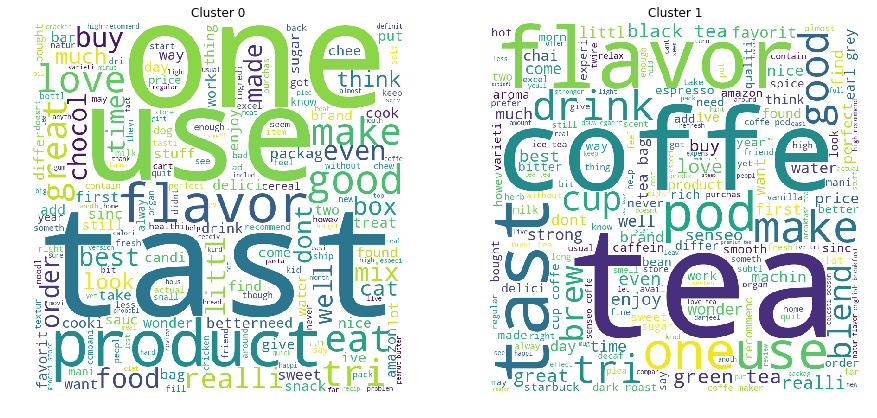

In [103]:
# Printing word clouds
fig = plt.figure(figsize=(15,15),facecolor=None)
for i in range(n):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(wordcloud[i])
    tit='Cluster '+str(i)
    ax.set_title(tit)
    ax.axis('off')

Popular words of cluster 0:one,tast,use,product,etc. popular words found in cluster 1 are tea,coffe,flavor,tast,etc.

## DBSCAN Clustering

In [108]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=4,min_samples=10).fit(standardized_X[:10000])
cluster_labels=clustering.labels_ 
outlier_length=len([i for i,x in enumerate(cluster_labels) if x == -1])
print "No. of points classified as outliers: ",outlier_length

No. of points classified as outliers:  2442


In [109]:
w=list(set(cluster_labels))
dicti={}
for j in range(len(w)):
    # Getting review indexes according to the clusters
    if w[j]!=-1:
        index=[i for i,x in enumerate(cluster_labels) if x == j]
        dicti[w[j]]=index

In [110]:
print "No of clusters: ",len(dicti)

No of clusters:  6


In [111]:
# Getting review words according to the clusters
cluster_words=[]
for j in range(len(dicti.keys())):
    index_list=dicti[j]
    words=' '
    for i in index_list:
        stmt=X[i]
        words=words+stmt+' '
    cluster_words.append(words)

In [112]:
# Plotting word cloud for each clusters
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)
wordcloud=[]
for i in range(len(dicti.keys())):
    wc=WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster_words[i])
    wordcloud.append(wc)

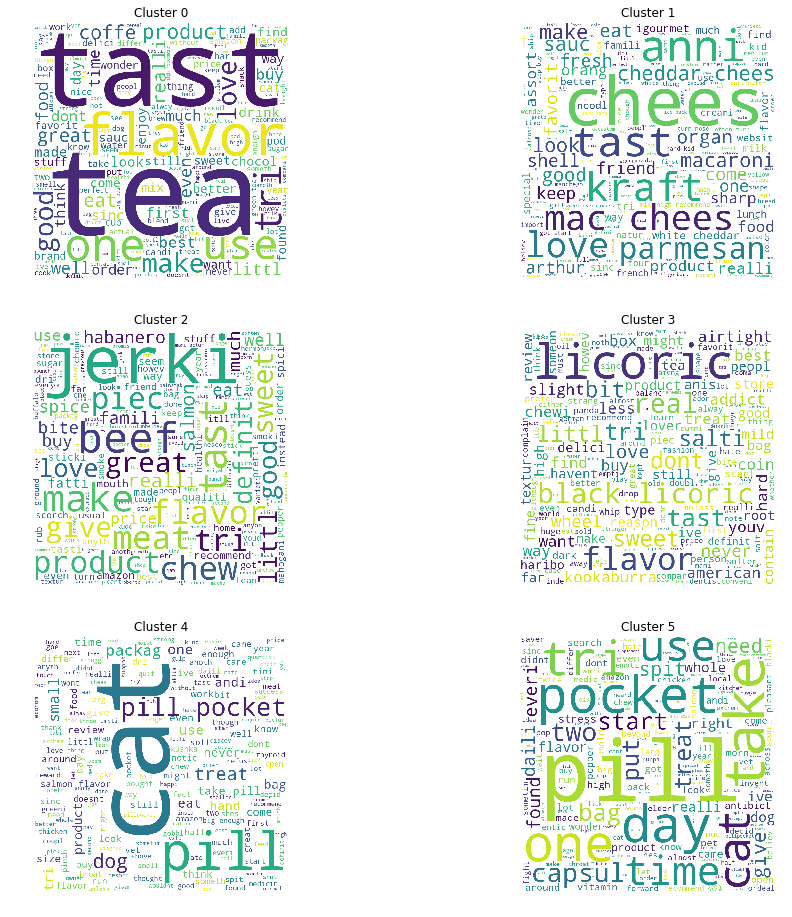

In [116]:
# Printing word clouds
fig = plt.figure(figsize=(16,16),facecolor=None)
for i in range(len(dicti.keys())):
    ax = fig.add_subplot(3,2,i+1)
    ax.imshow(wordcloud[i])
    tit='Cluster '+str(i)
    ax.set_title(tit)
    ax.axis('off')

Popular words of cluster 0: tea,tast,flavor,etc. popular words of cluster 1:chees,anni,craft,love,etc. popular words of cluster 2:jerki,beef,great. popular words of cluster 3:licoric,flavor,black. popular words of cluster 4: cat,pill,pocket. popular words of cluster 5:pill,pocket,day,one,time.etc.

For the amazon fine food reviews dataset, kmeans clustering, agglomerative clustering and DBSCAN clusstering.